# Forecasting Gross Broadway Sales using Facebook Prophet

Our goal in this notebook is to use Facebook Prophet to build a model that will predict the gross sales for a particular theater; in this case, Gershwin Theater.

## Setup

Let us first import the packages we need.

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

sns.set_style("whitegrid")

Next, we read in the data file `grosses.csv`.

In [81]:
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


Next, we perform a bit of exploration to see if there's anything odd about the data.

In [82]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           47524 non-null  object 
 1   week_number           47524 non-null  int64  
 2   weekly_gross_overall  47524 non-null  float64
 3   show                  47524 non-null  object 
 4   theatre               47524 non-null  object 
 5   weekly_gross          47524 non-null  float64
 6   potential_gross       34911 non-null  float64
 7   avg_ticket_price      47524 non-null  float64
 8   top_ticket_price      36167 non-null  float64
 9   seats_sold            47524 non-null  int64  
 10  seats_in_theatre      47524 non-null  int64  
 11  pct_capacity          47524 non-null  float64
 12  performances          47524 non-null  int64  
 13  previews              47524 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ MB


The columns we're interested in are `week_ending`, `theatre`, and `weekly_gross`. Happily, none of these columns have null values.

Let's also get some simple stats to get an idea of the numbers we're working with.

In [83]:
df_raw.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000


## Creating a DataFrame to feed to Prophet

Prophet requires a two-column DataFrame to build a model; the first column must be in `datetime` format, and the second column must be numerical. We need to manipulate `df_raw` to get the weekly grosses of Gershwin theater, indexed by the ending week.

First, let's extract all of the rows that have 'Gershwin Theater' in the `theatre` column.

In [84]:
df_gershwin = df_raw[df_raw['theatre'] == 'Gershwin Theatre']

Next, let's drop all columns except for `week_ending` and `weekly_gross`.

In [85]:
df_week_gross_series = df_gershwin[['week_ending', 'weekly_gross']]

And convert the `week_ending` column from string to `datetime` format.

In [86]:
df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])

<ipython-input-86-c999bfa3789d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])


Also, Prophet has the requirement that the two columns must be titled 'ds' and 'y', so let's rename them.

In [87]:
df_week_gross_series = df_week_gross_series.rename(columns={'week_ending': 'ds', 'weekly_gross': 'y'})

Next, we extract all rows between the dates 2013-06-02 and 2018-05-27, and preview the final DataFrame.

In [88]:
from datetime import datetime

train_start_date = datetime.strptime('2013-06-02', '%Y-%m-%d')
train_end_date = datetime.strptime('2018-05-27', '%Y-%m-%d')

test_start_date = datetime.strptime('2018-06-03', '%Y-%m-%d')
test_end_date = datetime.strptime('2019-05-26', '%Y-%m-%d')

df_full = df_week_gross_series.loc[(df_week_gross_series.ds >= train_start_date) & (df_week_gross_series.ds <= test_end_date)].reset_index(drop = True)
df_train = df_full.loc[df_full.ds <= train_end_date]
df_test = df_full.loc[df_full.ds >= test_start_date]

df_test

#for i in [df_full, df_train, df_test]:
 #   print(len(i))

,ds,y
260,2018-06-03,1854648.0
261,2018-06-10,1923023.0
262,2018-06-17,1945441.0
263,2018-06-24,1982377.0
264,2018-07-01,1963807.0
265,2018-07-08,1981742.0
266,2018-07-15,1864640.0
267,2018-07-22,1958763.0
268,2018-07-29,2199140.0
269,2018-08-05,1921398.0


Let's plot the evolution of the training data and the test data over time, to see how it looks.

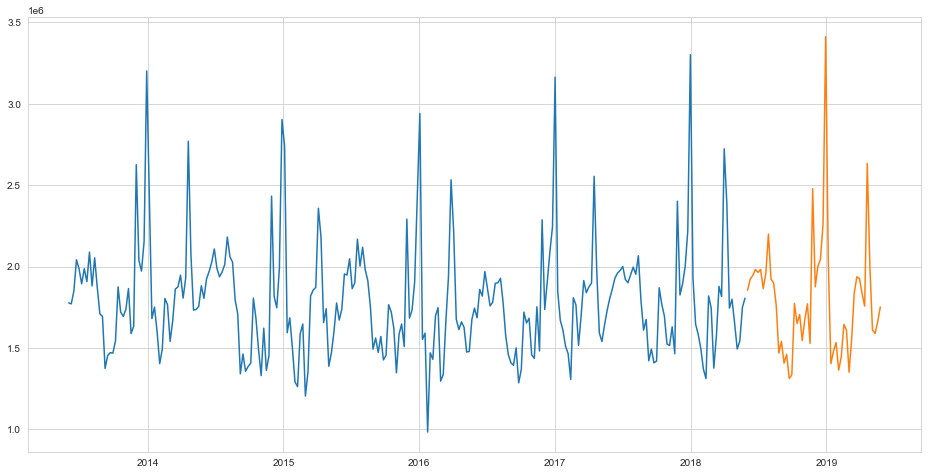

In [89]:
plt.figure(figsize=(16,8))
plt.plot(df_train['ds'], df_train['y'])
plt.plot(df_test['ds'], df_test['y'])

## Building a model

We call Prophet and fit it to our DataFrame `df_final`.

In [90]:
m = Prophet()
m.fit(df_train)

14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing


Next, we fill out the date column with 52 weeks into the future.

In [91]:
future = m.make_future_dataframe(periods = 52, freq = 'W')
future.tail()

,ds
307,2019-04-28
308,2019-05-05
309,2019-05-12
310,2019-05-19
311,2019-05-26


Then we call the `predict` method on `future`, to get predictions $\hat y$.

In [92]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-06-02,1.883982e+06,1.633882e+06,2.137066e+06
1,2013-06-09,1.902847e+06,1.654895e+06,2.152143e+06
2,2013-06-16,1.949264e+06,1.691127e+06,2.195539e+06
3,2013-06-23,2.023873e+06,1.782210e+06,2.271734e+06
4,2013-06-30,2.058809e+06,1.799555e+06,2.308213e+06


## Diagnostics

Next, we want to evaluate how well the model did. We add the actual values $y_t$ and the errors $|y_t-\hat y_t|$ to the `forecast` Data Frame.

In [93]:
forecast['actuals'] = df_full['y']
forecast['error'] = np.abs(forecast['actuals'] - forecast['yhat'])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actuals', 'error']].head(10)

,ds,yhat,yhat_lower,yhat_upper,actuals,error
0,2013-06-02,1.883982e+06,1.633882e+06,2.137066e+06,1776282.0,107699.608353
1,2013-06-09,1.902847e+06,1.654895e+06,2.152143e+06,1770507.0,132339.503348
2,2013-06-16,1.949264e+06,1.691127e+06,2.195539e+06,1849045.0,100219.242572
3,2013-06-23,2.023873e+06,1.782210e+06,2.271734e+06,2041391.0,17518.279043
4,2013-06-30,2.058809e+06,1.799555e+06,2.308213e+06,1985154.0,73654.995360
5,2013-07-07,2.014850e+06,1.769449e+06,2.259794e+06,1893488.0,121362.496776
6,2013-07-14,1.951369e+06,1.694658e+06,2.233488e+06,1986489.0,35120.380935
7,2013-07-21,1.963496e+06,1.706302e+06,2.222996e+06,1907228.0,56268.179982
8,2013-07-28,2.056578e+06,1.807508e+06,2.331160e+06,2088425.0,31846.556180
9,2013-08-04,2.121491e+06,1.866199e+06,2.387461e+06,1880559.0,240932.069054


Next we compute the Root Mean Squared Error on the test data, and divide it by the average actual value in the test data to get an idea of how far off the predictions are (the test data starts in `forecast` at index 260).

In [94]:
test_errors = forecast['error'][260:]
rmse = np.sqrt(1/len(test_errors)*np.sum(test_errors**2))
percent = rmse/np.mean(forecast['actuals'][260:])
print('The Root Mean Squared Error on the test data is ' + str(rmse) + '.')
print('So the predictions vary from the actual values by about ' + str(percent*100) + '% on average.')

The Root Mean Squared Error on the test data is 228755.83016067347.
So the predictions vary from the actual values by about 12.727931752841293% on average.


Below we plot the actual values against the predicted values, and plot the error below these two curves. The red dotted line indicates the separation between the train data and the test data (the model was trained only on the blue curve to the left of the red dotted line).

It is interesting to note that the error seems to peak when the actual values peak, i.e., the model is conservative when predicting around peaks. This suggests further tuning, such as taking holidays into account, might improve the model.

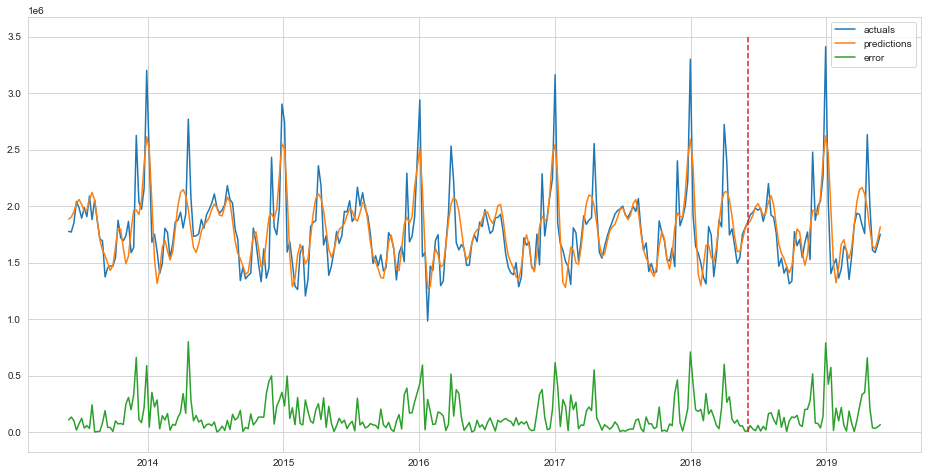

In [95]:
plt.figure(figsize=(16,8))
plt.plot(forecast['ds'], forecast['actuals'], label = 'actuals')
plt.plot(forecast['ds'], forecast['yhat'], label = 'predictions')
plt.plot(forecast['ds'], forecast['error'], label = 'error')
plt.plot([test_start_date, test_start_date], [0, 3500000], linestyle = '--')
plt.legend()